# **Learning on Graphs and its Applications (CSL7870)**

# **Assignment-2**

# **Khushal Damor (B21AI018)**

# **Setup**

In [1]:
# Installing Torch Geometric

!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00


In [2]:
# Installing sentence transformers

!pip install -U sentence-transformers

In [3]:
# Importing necessary libraries

import pandas as pd

import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from sentence_transformers import SentenceTransformer

import json

from torch_geometric.data import HeteroData, Data
from torch_geometric.nn import kge

import pprint

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.manifold import TSNE

import math

from typing import Tuple, List, Dict, Callable

import itertools

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
# Device

device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

# **1. Data Preprocessing**

**Download and Parse the CoDEx Dataset**

In [5]:
# Reference : https://github.com/tsafavi/codex

# unzip the repository
!git clone https://github.com/tsafavi/codex.git
%cd codex

# extract English Wikipedia plain-text excerpts for entities
# other language codes available: ar, de, es, ru, zh
!./extract.sh en

# set up a virtual environment and install the Python requirements
!python3.7 -m venv myenv
!source myenv/bin/activate
!pip install -r requirements.txt

# finally, install the codex data-loading API
!pip install -e .

Streaming output truncated to the last 5000 lines.
  inflating: data/entities/en/extracts/Q1822094.txt  
  inflating: data/entities/en/extracts/Q245817.txt  
  inflating: data/entities/en/extracts/Q55760.txt  
  inflating: data/entities/en/extracts/Q97926.txt  
  inflating: data/entities/en/extracts/Q366054.txt  
  inflating: data/entities/en/extracts/Q650792.txt  
  inflating: data/entities/en/extracts/Q70478.txt  
  inflating: data/entities/en/extracts/Q91589.txt  
  inflating: data/entities/en/extracts/Q182952.txt  
  inflating: data/entities/en/extracts/Q469735.txt  
  inflating: data/entities/en/extracts/Q387370.txt  
  inflating: data/entities/en/extracts/Q445304.txt  
  inflating: data/entities/en/extracts/Q129883.txt  
  inflating: data/entities/en/extracts/Q118570.txt  
  inflating: data/entities/en/extracts/Q164227.txt  
  inflating: data/entities/en/extracts/Q230299.txt  
  inflating: data/entities/en/extracts/Q237090.txt  
  inflating: data/entities/en/extracts/Q112939.txt 

In [6]:
# Reference : https://colab.research.google.com/github/tsafavi/codex/blob/master/Explore%20CoDEx.ipynb

# Loading the dataset : Codex-S

from codex.codex import Codex

codex = Codex(code = "en", size = "s")

train, valid, test = [
    codex.split(split) for split in ("train", "valid", "test")]
triples = codex.triples()

print(codex.name())

print(
    " ", len(codex.entities()), "entities /",
    len(codex.relations()), "relations"
)

print(
    " ", len(train), "train /",
    len(valid), "validation /",
    len(test), "test"
)
print(" ", len(triples), "total triples")

CoDEx-S
  2034 entities / 42 relations
  32888 train / 1827 validation / 1828 test
  36543 total triples


In [7]:
# Making sure that none of the negative triples are actually positives.

all_triples = {tuple(row) for row in pd.concat(
    [codex.triples()]).values}

valid_neg, test_neg = (
    codex.negative_split("valid"),
    codex.negative_split("test")
)

for neg_triples in (valid_neg, test_neg):
    neg_triples = {tuple(row) for row in neg_triples.values}
    assert not len(neg_triples.intersection(all_triples))

print("Passed all checks successfully")

Passed all checks successfully


In [8]:
# Loading the JSON files

with open("/content/codex/data/entities/en/entities.json","r") as entities_json_file:

  entities_json_data = json.load(entities_json_file)

with open("/content/codex/data/relations/en/relations.json","r") as relations_json_file:

  relations_json_data = json.load(relations_json_file)

**Extract Entity Descriptions**

In [9]:
# Function to extract the textual information

def extractTextualInformation(entity : str) -> str:

  global entities_json_data

  if entities_json_data[entity]['description'] != "":

    return entities_json_data[entity]['description']

  else:

    return entities_json_data[entity]['label']

In [10]:
# Entity dataframe

set_of_entities = list(codex.entities())

entity_df = pd.DataFrame({"Entity ID"           : [None for i in range(len(set_of_entities))],
                          "Index"               : [None for i in range(len(set_of_entities))],
                          "Textual Information" : [None for i in range(len(set_of_entities))]})

for i in range(len(set_of_entities)):

  entity_df.loc[i,"Entity ID"] = set_of_entities[i]
  entity_df.loc[i,"Index"] = i
  entity_df.loc[i,"Textual Information"] = extractTextualInformation(set_of_entities[i])

entity_df

,Entity ID,Index,Textual Information
0,Q130631,0,French philosopher
1,Q783992,1,Canadian musician
2,Q3986379,2,1984 film by Patrick Montgomery
3,Q216288,3,American country music singer
4,Q9711,4,French writer
...,...,...,...
2029,Q231276,2029,Beninese recording artist; musician
2030,Q25147,2030,"Italian singer-songwriter, composer, and filmm..."
2031,Q311115,2031,French physicist
2032,Q484523,2032,American actor and musician


**Preprocess Relation Information**

In [11]:
# Relation dataframe

set_of_relations = list(codex.relations())

relation_df = pd.DataFrame({"Relation ID" : [None for i in range(len(set_of_relations))],
                            "Index"       : [None for i in range(len(set_of_relations))]})

for i in range(len(set_of_relations)):

  relation_df.loc[i,"Relation ID"] = set_of_relations[i]
  relation_df.loc[i,"Index"] = i

relation_df

,Relation ID,Index
0,P35,0
1,P138,1
2,P737,2
3,P530,3
4,P172,4
5,P740,5
6,P463,6
7,P3095,7
8,P1303,8
9,P20,9


In [12]:
# Preparing the edge_index, edge_type and split_index tensors

edge_index = torch.empty((2,len(codex.triples())), dtype = torch.int64)
edge_type = torch.empty((len(codex.triples())), dtype = torch.int64)

set_of_train_triples = list(zip(train['head'],train['relation'],train['tail']))
set_of_validation_triples = list(zip(valid['head'],valid['relation'],valid['tail']))
set_of_test_triples = list(zip(test['head'],test['relation'],test['tail']))

split_index = torch.empty((len(codex.triples())), dtype = torch.int64)

for i in range(len(codex.triples())):

  edge_index[0][i] = entity_df.loc[codex.triples().iloc[i,0] == entity_df["Entity ID"],"Index"].astype(int).values[0]
  edge_index[1][i] = entity_df.loc[codex.triples().iloc[i,2] == entity_df["Entity ID"],"Index"].astype(int).values[0]

  edge_type[i] = relation_df.loc[codex.triples().iloc[i,1] == relation_df["Relation ID"],"Index"].astype(int).values[0]

  if (codex.triples().iloc[i,0],codex.triples().iloc[i,1],codex.triples().iloc[i,2]) in set_of_train_triples:

    split_index[i] = 0

  elif (codex.triples().iloc[i,0],codex.triples().iloc[i,1],codex.triples().iloc[i,2]) in set_of_validation_triples:

    split_index[i] = 1

  elif (codex.triples().iloc[i,0],codex.triples().iloc[i,1],codex.triples().iloc[i,2]) in set_of_test_triples:

    split_index[i] = 2

In [13]:
# Creating the dataset

codex_data = Data()

codex_data.edge_index = edge_index
codex_data.edge_type = edge_type

codex_data.train_mask = split_index == 0
codex_data.validation_mask = split_index == 1
codex_data.test_mask = split_index == 2

codex_data.all_triples = torch.empty((len(codex.triples()),3), dtype = torch.int64)
codex_data.all_triples[:,0] = codex_data.edge_index[0]
codex_data.all_triples[:,1] = codex_data.edge_type
codex_data.all_triples[:,2] = codex_data.edge_index[1]

codex_data = codex_data.to(device)

codex_data

Data(edge_index=[2, 36543], edge_type=[36543], train_mask=[36543], validation_mask=[36543], test_mask=[36543], all_triples=[36543, 3])

In [14]:
# Triplet Loader

class TripletLoader(torch.utils.data.DataLoader):

  def __init__(self,
               head_index    : torch.Tensor,
               relation_type : torch.Tensor,
               tail_index    : torch.Tensor,
               **kwargs):

    super().__init__(range(head_index.size(0)),
                     collate_fn = self.sample,
                     **kwargs)

    self.head_index_ = head_index
    self.tail_index_ = tail_index

    self.relation_type_ = relation_type

  def sample(self,
             index : torch.Tensor) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor]:

    index = torch.tensor(index,
                         device = self.head_index_.device)

    head_index = self.head_index_[index]
    tail_index = self.tail_index_[index]

    relation_type = self.relation_type_[index]

    return (head_index,relation_type,tail_index)

# **2. Entity Feature Initialization with LLM**

**LLM-based Embedding Generation**

In [15]:
# Reference : https://huggingface.co/sentence-transformers/all-mpnet-base-v2

textual_information = [entity_df.loc[i,"Textual Information"] for i in range(len(entity_df))]

model_mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
textual_information_embeddings = torch.tensor(model_mpnet.encode(textual_information))

print(textual_information_embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tensor([[ 0.0626,  0.1119,  0.0281,  ...,  0.0238,  0.0481, -0.0045],
        [-0.0163,  0.0840, -0.0097,  ...,  0.0023, -0.0274, -0.0071],
        [ 0.0310,  0.0168,  0.0036,  ...,  0.0074, -0.0136,  0.0036],
        ...,
        [ 0.0228,  0.0545, -0.0039,  ...,  0.0198,  0.0367, -0.0171],
        [-0.0190,  0.0495, -0.0146,  ..., -0.0202, -0.0341, -0.0391],
        [ 0.0112,  0.0772, -0.0116,  ..., -0.0056,  0.0430, -0.0363]])


**Feature Extraction and Embedding Storage**

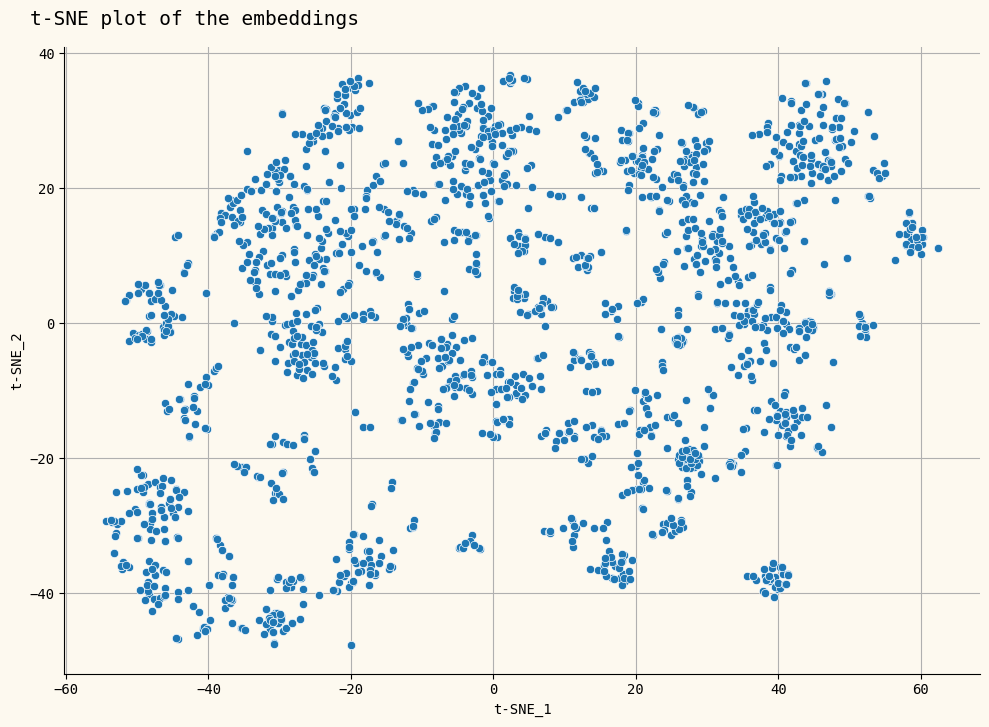

In [16]:
# t-SNE Plot for the wine Dataset

# Parchment like color
# https://htmlcolorcodes.com/colors/parchment/

parchment_color = '#FCF5E5'

# Font Family

plt.rcParams["font.family"] = "monospace"

fig, ax = plt.subplots(figsize = (10,7))

fig.patch.set_facecolor(parchment_color)
fig.patch.set_alpha(0.6)

tsne = TSNE(random_state = 31)

projections = pd.DataFrame(tsne.fit_transform(textual_information_embeddings.cpu().numpy()))

b = sns.scatterplot(data = projections,
                    x = 0,
                    y = 1)

b.set_axisbelow(True)

b.spines['right'].set_visible(False)
b.spines['top'].set_visible(False)

b.patch.set_facecolor(parchment_color)
b.patch.set_alpha(0.0)

b.grid()

b.set_xlabel("t-SNE_1")
b.set_ylabel("t-SNE_2")

# This is for displaying the text objects

fig.text(x = 0.035,
         y = 1.01,
         s = "t-SNE plot of the embeddings",
         fontsize = 14,
         fontweight = 'medium')

# This is for the automatic adjustment of the layout

fig.tight_layout()

# This is for saving the image

fig.savefig(fname = 'tsne_embeddings.pdf',
            dpi = 1200,
            bbox_inches = 'tight')

# **3. Graph Neural Network Model Design**

**GNN Architecture Selection**

In [17]:
# I will use the TransE model. It can handle multi-relational data.
# More details are present in the report.
# Reference : https://proceedings.neurips.cc/paper_files/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf

**Model Implementation**

In [18]:
# TransE Implementation

class myTransE(torch.nn.Module):

  def __init__(self,
               number_of_entities       : int,
               number_of_relation_types : int,
               hidden_dimension         : int,
               margin                   : float,
               p_norm                   : float,
               sparse                   : bool):

    super().__init__()

    # Initializing the class variables

    self.number_of_entities_ = number_of_entities
    self.number_of_relation_types_ = number_of_relation_types

    self.hidden_dimension_ = hidden_dimension
    self.margin_ = margin
    self.p_norm_ = p_norm

    self.sparse_ = sparse

    # Initializing the embedding tables for entities and relations

    self.entity_embeddings = torch.nn.Embedding(num_embeddings = self.number_of_entities_,
                                                embedding_dim  = self.hidden_dimension_,
                                                sparse         = self.sparse_)

    self.relation_embeddings = torch.nn.Embedding(num_embeddings = self.number_of_relation_types_,
                                                  embedding_dim  = self.hidden_dimension_,
                                                  sparse         = self.sparse_)

    self.reset_parameters()

  def reset_parameters(self):

    # Initializing/Resetting the embeddings

    bound = 6.0 / math.sqrt(self.hidden_dimension_)

    torch.nn.init.uniform_(tensor = self.entity_embeddings.weight,
                           a      = -bound,
                           b      = bound)

    torch.nn.init.uniform_(tensor = self.relation_embeddings.weight,
                           a      = -bound,
                           b      = bound)

    F.normalize(input = self.relation_embeddings.weight.data,
                p     = self.p_norm_,
                dim   = -1,
                out   = self.relation_embeddings.weight.data)

  def forward(self,
              head_index    : torch.Tensor,
              relation_type : torch.Tensor,
              tail_index    : torch.Tensor) -> torch.Tensor:

    # Calculating and returning the energy of the triple

    head_embedding = self.entity_embeddings(head_index)
    head_embedding = F.normalize(input = head_embedding,
                                 p     = self.p_norm_,
                                 dim   = -1)

    tail_embedding = self.entity_embeddings(tail_index)
    tail_embedding = F.normalize(input = tail_embedding,
                                 p     = self.p_norm_,
                                 dim   = -1)

    relation_embedding = self.relation_embeddings(relation_type)

    energy = ((head_embedding + relation_embedding) - tail_embedding).norm(p   = self.p_norm_,
                                                                           dim = -1)

    return energy

  def loss(self,
           head_index    : torch.Tensor,
           relation_type : torch.Tensor,
           tail_index    : torch.Tensor) -> torch.Tensor:

    # Calculating and returning the value of the loss function

    energy_of_positive_triple = self.forward(head_index,
                                             relation_type,
                                             tail_index)

    energy_of_negative_triple = self.forward(*self.random_sample(head_index,
                                                                 relation_type,
                                                                 tail_index))

    loss = F.margin_ranking_loss(input1 = energy_of_positive_triple,
                                 input2 = energy_of_negative_triple,
                                 target = -torch.ones_like(energy_of_positive_triple),
                                 margin = self.margin_)

    return loss

  @torch.no_grad()
  def random_sample(self,
                    head_index    : torch.Tensor,
                    relation_type : torch.Tensor,
                    tail_index    : torch.Tensor) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor]:

    # Either perturbing the head of a positive triple or the tail of the positive triple, but not both.

    number_of_negative_triples = head_index.size(0)

    random_index = torch.randint(high   = self.number_of_entities_,
                                 size   = head_index.size(),
                                 device = device)

    perturbed_head_index = head_index.clone()
    perturbed_head_index[:number_of_negative_triples // 2] = random_index[:number_of_negative_triples // 2]

    perturbed_tail_index = tail_index.clone()
    perturbed_tail_index[number_of_negative_triples // 2:] = random_index[number_of_negative_triples // 2:]

    return (perturbed_head_index,relation_type,perturbed_tail_index)

# **4. Knowledge Base Completion Task**

**Training and Testing Setup**

In [19]:
# Training Step

def training_step(loader    : TripletLoader,
                  model     : torch.nn.Module,
                  optimizer : torch.optim.Optimizer):

    # Setting the model to "train" mode

    model.train(True)

    # Getting the number of batches

    number_of_batches = len(loader)

    # Initializing the training loss to 0

    training_loss = 0

    # Looping through each batch (Mini-Batch Stochastic Gradient Descent)

    for batch, (head_index,relation_type,tail_index) in enumerate(loader):

        # Setting the gradients to 0

        optimizer.zero_grad()

        # Sending the batch to the device

        head_index = head_index.to(device)
        tail_index = tail_index.to(device)

        relation_type = relation_type.to(device)

        # Computing the loss

        loss = model.loss(head_index,relation_type,tail_index)
        training_loss += loss.item()

        # Backpropagating the loss

        loss.backward()

        # Updating the parameters

        optimizer.step()

    # Calculating the average training loss

    average_training_loss = training_loss / number_of_batches

    # Returning the average training loss

    return average_training_loss

In [20]:
# Function to calculate the energy

@torch.no_grad()
def calculate_energy(h     : torch.Tensor,
                     r     : torch.Tensor,
                     t     : torch.Tensor,
                     model : torch.nn.Module,
                     mode  : str):

  if mode == "hr_":

    head_embedding = model.entity_embeddings(h)
    relation_embedding = model.relation_embeddings(r)

    tail_embedding = model.entity_embeddings.weight.data

    return torch.cdist(x1           = head_embedding + relation_embedding,
                       x2           = tail_embedding,
                       p            = model.p_norm_,
                       compute_mode = "donot_use_mm_for_euclid_dist")

  elif mode == "_rt":

    head_embedding = model.entity_embeddings.weight.data

    relation_embedding = model.relation_embeddings(r)
    tail_embedding = model.entity_embeddings(t)

    return torch.cdist(x1           = tail_embedding - relation_embedding,
                       x2           = head_embedding,
                       p            = model.p_norm_,
                       compute_mode = "donot_use_mm_for_euclid_dist")

In [21]:
# Evaluation
# Reference : https://github.com/tsafavi/codex/blob/master/scripts/baseline.py

def evaluation(head_index      : torch.Tensor,
               relation_type   : torch.Tensor,
               tail_index      : torch.Tensor,
               all_triples     : torch.Tensor,
               model           : torch.nn.Module) -> pd.DataFrame:

    set_of_relations_in_evaluation_triples = list(set(relation_type.cpu().tolist()))

    list_of_relation_evaluation_df = []

    evaluation_triples = torch.stack([head_index,relation_type,tail_index], dim = 1)

    for relation in set_of_relations_in_evaluation_triples:

      head_index = evaluation_triples[evaluation_triples[:, 1] == relation][:, 0]
      tail_index = evaluation_triples[evaluation_triples[:, 1] == relation][:, 2]

      relation_type = evaluation_triples[evaluation_triples[:, 1] == relation][:, 1]

      # Initializing the lists and dictionaries to store the evaulation metric values

      relation_evaluation_df = pd.DataFrame({"Head"                 : [None for i in range(head_index.size(0))],
                                             "Relation"             : [None for i in range(head_index.size(0))],
                                             "Tail"                 : [None for i in range(head_index.size(0))],
                                             "Tail Rank"            : [None for i in range(head_index.size(0))],
                                             "Reciprocal Tail Rank" : [None for i in range(head_index.size(0))],
                                             "Tail Hits@1"          : [None for i in range(head_index.size(0))],
                                             "Tail Hits@3"          : [None for i in range(head_index.size(0))],
                                             "Tail Hits@10"         : [None for i in range(head_index.size(0))],
                                             "Head Rank"            : [None for i in range(head_index.size(0))],
                                             "Reciprocal Head Rank" : [None for i in range(head_index.size(0))],
                                             "Head Hits@1"          : [None for i in range(head_index.size(0))],
                                             "Head Hits@3"          : [None for i in range(head_index.size(0))],
                                             "Head Hits@10"         : [None for i in range(head_index.size(0))]})

      # Looping through each triple

      # Simplified notation for the ith triple (head_index,relation_type,tail_index)

      h, r, t = (head_index,relation_type,tail_index)

      relation_evaluation_df["Head"] = h.cpu().tolist()
      relation_evaluation_df["Tail"] = t.cpu().tolist()

      relation_evaluation_df["Relation"] = r.cpu().tolist()

      # [TAIL]

      # Tail prediction queries : (h,r,_)

      tail_prediction_energies = -calculate_energy(h,r,t,model,"hr_")

      # Filtering the tail prediction energies.
      # Setting energy of (h,r,_) to infinity if (h,r,_) is already part of the graph

      for i in range(head_index.size(0)):

        tail_filter_index = all_triples[(all_triples[:, 1] == relation_type[i]) & (all_triples[:, 0] == head_index[i]) & (all_triples[:, 2] != tail_index[i])][:, 2]
        tail_prediction_energies[i, tail_filter_index] = float("-Inf")

      tail_prediction_energies[torch.isnan(tail_prediction_energies)] = float("-Inf")

      # Setting energy of (h,r,t) to infinity

      arange = torch.arange(head_index.size(0),
                            dtype = torch.long)
      tail_true_energy = tail_prediction_energies[arange,t].view(-1, 1)
      tail_prediction_energies = tail_prediction_energies.clone()
      tail_prediction_energies[arange,t] = float("-Inf")

      tail_rank = torch.sum(input = tail_prediction_energies > tail_true_energy,
                            dim   = 1,
                            dtype = torch.double)
      tail_number_of_ties = torch.sum(input = tail_prediction_energies == tail_true_energy,
                                      dim   = 1,
                                      dtype = torch.double)
      tail_rank = (tail_rank + tail_number_of_ties // 2 + 1).cpu()

      relation_evaluation_df["Tail Rank"] = tail_rank.tolist()
      relation_evaluation_df["Reciprocal Tail Rank"] = (1 / tail_rank).tolist()
      relation_evaluation_df["Tail Hits@1"] = tail_rank <= 1
      relation_evaluation_df["Tail Hits@3"] = tail_rank <= 3
      relation_evaluation_df["Tail Hits@10"] = tail_rank <= 10

      # [HEAD]

      # Head prediction queries : (_,r,t)

      head_prediction_energies = -calculate_energy(h,r,t,model,"_rt")

      # Filtering the head prediction energies.
      # Setting energy of (_,r,t) to infinity if (_,r,t) is already part of the graph

      for i in range(head_index.size(0)):

        head_filter_index = all_triples[(all_triples[:, 1] == relation_type[i]) & (all_triples[:, 0] != head_index[i]) & (all_triples[:, 2] == tail_index[i])][:, 0]
        head_prediction_energies[i, head_filter_index] = float("-Inf")

      head_prediction_energies[torch.isnan(head_prediction_energies)] = float("-Inf")

      # Setting energy of (h,r,t) to infinity

      arange = torch.arange(head_index.size(0),
                            dtype = torch.long)
      head_true_energy = head_prediction_energies[arange,h].view(-1, 1)
      head_prediction_energies = head_prediction_energies.clone()
      head_prediction_energies[arange,h] = float("-Inf")

      head_rank = torch.sum(input = head_prediction_energies > head_true_energy,
                            dim   = 1,
                            dtype = torch.double)
      head_number_of_ties = torch.sum(input = head_prediction_energies == head_true_energy,
                                      dim   = 1,
                                      dtype = torch.double)
      head_rank = (head_rank + head_number_of_ties // 2 + 1).cpu()

      relation_evaluation_df["Head Rank"] = head_rank.tolist()
      relation_evaluation_df["Reciprocal Head Rank"] = (1 / head_rank).tolist()
      relation_evaluation_df["Head Hits@1"] = head_rank <= 1
      relation_evaluation_df["Head Hits@3"] = head_rank <= 3
      relation_evaluation_df["Head Hits@10"] = head_rank <= 10

      list_of_relation_evaluation_df.append(relation_evaluation_df)

    evaluation_df = pd.concat(list_of_relation_evaluation_df)

    return evaluation_df

In [22]:
# Training loop

def train(loader     : torch.utils.data.DataLoader,
          model      : torch.nn.Module,
          optimizer  : torch.optim.Optimizer,
          scheduler  : torch.optim.lr_scheduler,
          epochs     : int,
          evaluation : Callable,
          save_as    : str):

    print("START OF TRAINING")
    print()

    # Initializing the best mrr to 0

    best_mrr = 0

    for epoch in range(1,epochs + 1):

        # Training Step

        ith_average_training_loss = training_step(loader,
                                                  model,
                                                  optimizer)

        # Printing the results

        print(f"  Epoch [{epoch:0{len(str(epochs))}d}/{epochs}] | Avg. T-Loss (MR) : {ith_average_training_loss:.2f}")

        if epoch % 5 == 0:

          validation_df = evaluation(head_index    = codex_data.edge_index[0][codex_data.validation_mask],
                                     relation_type = codex_data.edge_type[codex_data.validation_mask],
                                     tail_index    = codex_data.edge_index[1][codex_data.validation_mask],
                                     all_triples   = codex_data.all_triples,
                                     model         = model)

          validation_dictionary = {"MRR"     : (sum(validation_df["Reciprocal Tail Rank"]) + sum(validation_df["Reciprocal Head Rank"])) / (2 * len(validation_df)),
                                   "Hits@1"  : (sum(validation_df["Tail Hits@1"])  + sum(validation_df["Head Hits@1"]))  / (2 * len(validation_df)),
                                   "Hits@3"  : (sum(validation_df["Tail Hits@3"])  + sum(validation_df["Head Hits@3"]))  / (2 * len(validation_df)),
                                   "Hits@10" : (sum(validation_df["Tail Hits@10"]) + sum(validation_df["Head Hits@10"])) / (2 * len(validation_df))}

          print()
          print(f"(Validation Results after {epoch} Epochs)")
          print()
          pprint.pp(validation_dictionary)
          print()

          # Saving the model

          if validation_dictionary['MRR'] > best_mrr:

            best_mrr = validation_dictionary['MRR']

            torch.save(model.state_dict(), save_as)

        # Learning rate scheduler step

        scheduler.step(ith_average_training_loss)

    print("END OF TRAINING")
    print()

**(1) Random Initialization of Entity Embeddings**

In [23]:
# Training and validation

train_loader = TripletLoader(head_index    = codex_data.edge_index[0][codex_data.train_mask],
                             relation_type = codex_data.edge_type[codex_data.train_mask],
                             tail_index    = codex_data.edge_index[1][codex_data.train_mask],
                             batch_size    = 128,
                             shuffle       = True)

model_transe = myTransE(number_of_entities       = len(codex.entities()),
                        number_of_relation_types = len(set(codex_data.edge_type.cpu().numpy().tolist())),
                        hidden_dimension         = textual_information_embeddings.size(1),
                        margin                   = 0.5,
                        p_norm                   = 4.0,
                        sparse                   = False).to(device)

epochs = 250

learning_rate = 0.001

optimizer = torch.optim.Adam(params = model_transe.parameters(),
                             lr     = learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,
                                                       mode      = 'min')

train(train_loader,
      model_transe,
      optimizer,
      scheduler,
      epochs,
      evaluation,
      'random')

START OF TRAINING

  Epoch [001/250] | Avg. T-Loss (MR) : 0.44
  Epoch [002/250] | Avg. T-Loss (MR) : 0.32
  Epoch [003/250] | Avg. T-Loss (MR) : 0.26
  Epoch [004/250] | Avg. T-Loss (MR) : 0.20
  Epoch [005/250] | Avg. T-Loss (MR) : 0.17

(Validation Results after 5 Epochs)

{'MRR': 0.182554177753894,
 'Hits@1': 0.07936507936507936,
 'Hits@3': 0.21291735084838534,
 'Hits@10': 0.4017515051997811}

  Epoch [006/250] | Avg. T-Loss (MR) : 0.15
  Epoch [007/250] | Avg. T-Loss (MR) : 0.13
  Epoch [008/250] | Avg. T-Loss (MR) : 0.12
  Epoch [009/250] | Avg. T-Loss (MR) : 0.11
  Epoch [010/250] | Avg. T-Loss (MR) : 0.10

(Validation Results after 10 Epochs)

{'MRR': 0.2340607433540082,
 'Hits@1': 0.1116584564860427,
 'Hits@3': 0.28653530377668307,
 'Hits@10': 0.48084291187739464}

  Epoch [011/250] | Avg. T-Loss (MR) : 0.09
  Epoch [012/250] | Avg. T-Loss (MR) : 0.09
  Epoch [013/250] | Avg. T-Loss (MR) : 0.08
  Epoch [014/250] | Avg. T-Loss (MR) : 0.08
  Epoch [015/250] | Avg. T-Loss (MR) : 

**(2) LMM-Based Initialization of Entity Embeddings**

In [24]:
# Training and validation

train_loader = TripletLoader(head_index    = codex_data.edge_index[0][codex_data.train_mask],
                             relation_type = codex_data.edge_type[codex_data.train_mask],
                             tail_index    = codex_data.edge_index[1][codex_data.train_mask],
                             batch_size    = 128,
                             shuffle       = True)

model_transe = myTransE(number_of_entities       = len(codex.entities()),
                        number_of_relation_types = len(set(codex_data.edge_type.cpu().numpy().tolist())),
                        hidden_dimension         = textual_information_embeddings.size(1),
                        margin                   = 0.5,
                        p_norm                   = 4.0,
                        sparse                   = False).to(device)

# Initializing the embeddings of the entities with the embeddings of their textual information

model_transe.entity_embeddings.weight.data = textual_information_embeddings.clone().to(device)

epochs = 250

learning_rate = 0.001

optimizer = torch.optim.Adam(params = model_transe.parameters(),
                             lr     = learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,
                                                       mode      = 'min')

train(train_loader,
      model_transe,
      optimizer,
      scheduler,
      epochs,
      evaluation,
      'llm')

START OF TRAINING

  Epoch [001/250] | Avg. T-Loss (MR) : 0.20
  Epoch [002/250] | Avg. T-Loss (MR) : 0.10
  Epoch [003/250] | Avg. T-Loss (MR) : 0.08
  Epoch [004/250] | Avg. T-Loss (MR) : 0.07
  Epoch [005/250] | Avg. T-Loss (MR) : 0.07

(Validation Results after 5 Epochs)

{'MRR': 0.22549447448651283,
 'Hits@1': 0.13136288998357964,
 'Hits@3': 0.2523262178434592,
 'Hits@10': 0.4066776135741653}

  Epoch [006/250] | Avg. T-Loss (MR) : 0.07
  Epoch [007/250] | Avg. T-Loss (MR) : 0.06
  Epoch [008/250] | Avg. T-Loss (MR) : 0.06
  Epoch [009/250] | Avg. T-Loss (MR) : 0.06
  Epoch [010/250] | Avg. T-Loss (MR) : 0.06

(Validation Results after 10 Epochs)

{'MRR': 0.24789171935183144,
 'Hits@1': 0.15243568691844553,
 'Hits@3': 0.27285166940339356,
 'Hits@10': 0.4452654625068418}

  Epoch [011/250] | Avg. T-Loss (MR) : 0.06
  Epoch [012/250] | Avg. T-Loss (MR) : 0.06
  Epoch [013/250] | Avg. T-Loss (MR) : 0.05
  Epoch [014/250] | Avg. T-Loss (MR) : 0.05
  Epoch [015/250] | Avg. T-Loss (MR) 

**Evaluation and Metrics**

**(1) Random Initialization of Entity Embeddings**

In [25]:
# Test

model_transe.load_state_dict(torch.load("random", weights_only = True))

test_df = evaluation(head_index    = codex_data.edge_index[0][codex_data.test_mask],
                     relation_type = codex_data.edge_type[codex_data.test_mask],
                     tail_index    = codex_data.edge_index[1][codex_data.test_mask],
                     all_triples   = codex_data.all_triples,
                     model         = model_transe)

test_dictionary = {"MRR"     : (sum(test_df["Reciprocal Tail Rank"]) + sum(test_df["Reciprocal Head Rank"])) / (2 * len(test_df)),
                   "Hits@1"  : (sum(test_df["Tail Hits@1"])  + sum(test_df["Head Hits@1"]))  / (2 * len(test_df)),
                   "Hits@3"  : (sum(test_df["Tail Hits@3"])  + sum(test_df["Head Hits@3"]))  / (2 * len(test_df)),
                   "Hits@10" : (sum(test_df["Tail Hits@10"]) + sum(test_df["Head Hits@10"])) / (2 * len(test_df))}

print()
print(f"(Test Results)")
print()
pprint.pp(test_dictionary)
print()


(Test Results)

{'MRR': 0.29212727822768336,
 'Hits@1': 0.1701312910284464,
 'Hits@3': 0.3361597374179431,
 'Hits@10': 0.5421225382932167}



In [26]:
# Detailed test results

test_df

,Head,Relation,Tail,Tail Rank,Reciprocal Tail Rank,Tail Hits@1,Tail Hits@3,Tail Hits@10,Head Rank,Reciprocal Head Rank,Head Hits@1,Head Hits@3,Head Hits@10
0,1677,0,711,1.0,1.000000,True,True,True,2.0,0.500000,False,True,True
1,824,0,1006,319.0,0.003135,False,False,False,4.0,0.250000,False,False,True
0,547,1,815,89.0,0.011236,False,False,False,863.0,0.001159,False,False,False
0,815,2,174,2.0,0.500000,False,True,True,34.0,0.029412,False,False,False
1,302,2,696,12.0,0.083333,False,False,False,28.0,0.035714,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,624,40,1113,166.0,0.006024,False,False,False,10.0,0.100000,False,False,True
1,1206,40,709,585.0,0.001709,False,False,False,168.0,0.005952,False,False,False
0,339,41,906,1.0,1.000000,True,True,True,312.0,0.003205,False,False,False
1,1268,41,906,2.0,0.500000,False,True,True,369.0,0.002710,False,False,False


**(2) LMM-Based Initialization of Entity Embeddings**

In [27]:
# Test

model_transe.load_state_dict(torch.load("llm", weights_only = True))

test_df = evaluation(head_index    = codex_data.edge_index[0][codex_data.test_mask],
                     relation_type = codex_data.edge_type[codex_data.test_mask],
                     tail_index    = codex_data.edge_index[1][codex_data.test_mask],
                     all_triples   = codex_data.all_triples,
                     model         = model_transe)

test_dictionary = {"MRR"     : (sum(test_df["Reciprocal Tail Rank"]) + sum(test_df["Reciprocal Head Rank"])) / (2 * len(test_df)),
                   "Hits@1"  : (sum(test_df["Tail Hits@1"])  + sum(test_df["Head Hits@1"]))  / (2 * len(test_df)),
                   "Hits@3"  : (sum(test_df["Tail Hits@3"])  + sum(test_df["Head Hits@3"]))  / (2 * len(test_df)),
                   "Hits@10" : (sum(test_df["Tail Hits@10"]) + sum(test_df["Head Hits@10"])) / (2 * len(test_df))}

print()
print(f"(Test Results)")
print()
pprint.pp(test_dictionary)
print()


(Test Results)

{'MRR': 0.2712152634394149,
 'Hits@1': 0.1512582056892779,
 'Hits@3': 0.31099562363238514,
 'Hits@10': 0.513402625820569}



In [28]:
# Detailed test results

test_df

,Head,Relation,Tail,Tail Rank,Reciprocal Tail Rank,Tail Hits@1,Tail Hits@3,Tail Hits@10,Head Rank,Reciprocal Head Rank,Head Hits@1,Head Hits@3,Head Hits@10
0,1677,0,711,1.0,1.000000,True,True,True,4.0,0.250000,False,False,True
1,824,0,1006,10.0,0.100000,False,False,True,1.0,1.000000,True,True,True
0,547,1,815,541.0,0.001848,False,False,False,1346.0,0.000743,False,False,False
0,815,2,174,1.0,1.000000,True,True,True,17.0,0.058824,False,False,False
1,302,2,696,33.0,0.030303,False,False,False,20.0,0.050000,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,624,40,1113,1118.0,0.000894,False,False,False,28.0,0.035714,False,False,False
1,1206,40,709,401.0,0.002494,False,False,False,12.0,0.083333,False,False,False
0,339,41,906,1.0,1.000000,True,True,True,318.0,0.003145,False,False,False
1,1268,41,906,1.0,1.000000,True,True,True,539.0,0.001855,False,False,False


**Hyperparameter Tuning**

In [29]:
# Hyperparameter tuning dataframe

hyperparameter_df = pd.DataFrame(columns=('Margin','Norm','MRR','Hits@1','Hits@3','Hits@10'))

margin = [0.5,1,3]
norm = [1,2,4]

index = 0

for i in itertools.product(margin,norm):

  print(f"{index + 1}. Hyperparameter Combination [Margin = {i[0]}, Norm = {i[1]}]")
  print()

  # Training and validation

  train_loader = TripletLoader(head_index    = codex_data.edge_index[0][codex_data.train_mask],
                              relation_type = codex_data.edge_type[codex_data.train_mask],
                              tail_index    = codex_data.edge_index[1][codex_data.train_mask],
                              batch_size    = 128,
                              shuffle       = True)

  model_transe = myTransE(number_of_entities       = len(codex.entities()),
                          number_of_relation_types = len(set(codex_data.edge_type.cpu().numpy().tolist())),
                          hidden_dimension         = textual_information_embeddings.size(1),
                          margin                   = i[0],
                          p_norm                   = i[1],
                          sparse                   = False).to(device)

  # Initializing the embeddings of the entities with the embeddings of their textual information

  model_transe.entity_embeddings.weight.data = textual_information_embeddings.clone().to(device)

  epochs = 100

  learning_rate = 0.001

  optimizer = torch.optim.Adam(params = model_transe.parameters(),
                               lr     = learning_rate)

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,
                                                         mode      = 'min')

  train(train_loader,
        model_transe,
        optimizer,
        scheduler,
        epochs,
        evaluation,
        f'llm_{index}')

  # Test

  model_transe.load_state_dict(torch.load(f"llm_{index}", weights_only = True))

  test_df = evaluation(head_index    = codex_data.edge_index[0][codex_data.test_mask],
                       relation_type = codex_data.edge_type[codex_data.test_mask],
                       tail_index    = codex_data.edge_index[1][codex_data.test_mask],
                       all_triples   = codex_data.all_triples,
                       model         = model_transe)

  test_dictionary = {"MRR"     : (sum(test_df["Reciprocal Tail Rank"]) + sum(test_df["Reciprocal Head Rank"])) / (2 * len(test_df)),
                     "Hits@1"  : (sum(test_df["Tail Hits@1"])  + sum(test_df["Head Hits@1"]))  / (2 * len(test_df)),
                     "Hits@3"  : (sum(test_df["Tail Hits@3"])  + sum(test_df["Head Hits@3"]))  / (2 * len(test_df)),
                     "Hits@10" : (sum(test_df["Tail Hits@10"]) + sum(test_df["Head Hits@10"])) / (2 * len(test_df))}

  print(f"(Test Results)")
  print()
  pprint.pp(test_dictionary)
  print()

  hyperparameter_df.loc[index] = [i[0],i[1],test_dictionary['MRR'],test_dictionary['Hits@1'],test_dictionary['Hits@3'],test_dictionary['Hits@10']]

  index += 1

1. Hyperparameter Combination [Margin = 0.5, Norm = 1]

START OF TRAINING

  Epoch [001/100] | Avg. T-Loss (MR) : 0.17
  Epoch [002/100] | Avg. T-Loss (MR) : 0.13
  Epoch [003/100] | Avg. T-Loss (MR) : 0.12
  Epoch [004/100] | Avg. T-Loss (MR) : 0.11
  Epoch [005/100] | Avg. T-Loss (MR) : 0.11

(Validation Results after 5 Epochs)

{'MRR': 0.026165787543008277,
 'Hits@1': 0.0,
 'Hits@3': 0.026272577996715927,
 'Hits@10': 0.07389162561576355}

  Epoch [006/100] | Avg. T-Loss (MR) : 0.11
  Epoch [007/100] | Avg. T-Loss (MR) : 0.11
  Epoch [008/100] | Avg. T-Loss (MR) : 0.10
  Epoch [009/100] | Avg. T-Loss (MR) : 0.10
  Epoch [010/100] | Avg. T-Loss (MR) : 0.10

(Validation Results after 10 Epochs)

{'MRR': 0.024673017307081824,
 'Hits@1': 0.0,
 'Hits@3': 0.023809523809523808,
 'Hits@10': 0.06978653530377668}

  Epoch [011/100] | Avg. T-Loss (MR) : 0.10
  Epoch [012/100] | Avg. T-Loss (MR) : 0.10
  Epoch [013/100] | Avg. T-Loss (MR) : 0.10
  Epoch [014/100] | Avg. T-Loss (MR) : 0.09
  Epoc

In [30]:
# Results of hyperparameter tuning

hyperparameter_df

,Margin,Norm,MRR,Hits@1,Hits@3,Hits@10
0,0.5,1.0,0.025463,0.000000,0.024617,0.065919
1,0.5,2.0,0.245268,0.140591,0.271061,0.463895
2,0.5,4.0,0.276428,0.162746,0.307166,0.510667
3,1.0,1.0,0.024761,0.000000,0.028720,0.067013
4,1.0,2.0,0.192349,0.099289,0.203501,0.397976
5,1.0,4.0,0.251830,0.139497,0.291028,0.476477
6,3.0,1.0,0.017264,0.000821,0.018873,0.045405
7,3.0,2.0,0.082378,0.027626,0.064278,0.177243
8,3.0,4.0,0.165950,0.087527,0.167943,0.351477


# **5. Analysis and Report**

**Analysis of LLM Embedding Impact**

In [53]:
# Helper function for analysis

def getAnalysis(load_as : str) -> pd.DataFrame:

  global model_transe, codex, codex_data, relation_df

  model_transe.load_state_dict(torch.load(load_as, weights_only = True))

  evaluation_df = evaluation(head_index    = codex_data.edge_index[0][codex_data.test_mask],
                             relation_type = codex_data.edge_type[codex_data.test_mask],
                             tail_index    = codex_data.edge_index[1][codex_data.test_mask],
                             all_triples   = codex_data.all_triples,
                             model         = model_transe)

  analysis_df = pd.DataFrame(columns = ('Relation ID','Relation Label','Count','MRR','Hits@1','Hits@3','Hits@10',))

  index = 0

  for relation_index in set(evaluation_df['Relation']):

    relation_id = relation_df[relation_df['Index'] == relation_index]["Relation ID"].values[0]
    relation_label = codex.relation_label(relation_id)
    relation_dedcription = codex.relation_description(relation_id)

    relation_evaluation_df = evaluation_df[evaluation_df['Relation'] == relation_index]

    relation_evaluation_dictionary = {"MRR"     : (sum(relation_evaluation_df["Reciprocal Tail Rank"]) + sum(relation_evaluation_df["Reciprocal Head Rank"])) / (2 * len(relation_evaluation_df)),
                                      "Hits@1"  : (sum(relation_evaluation_df["Tail Hits@1"])  + sum(relation_evaluation_df["Head Hits@1"]))  / (2 * len(relation_evaluation_df)),
                                      "Hits@3"  : (sum(relation_evaluation_df["Tail Hits@3"])  + sum(relation_evaluation_df["Head Hits@3"]))  / (2 * len(relation_evaluation_df)),
                                      "Hits@10" : (sum(relation_evaluation_df["Tail Hits@10"]) + sum(relation_evaluation_df["Head Hits@10"])) / (2 * len(relation_evaluation_df))}

    analysis_df.loc[index] = [relation_index,relation_label,len(relation_evaluation_df),relation_evaluation_dictionary['MRR'],relation_evaluation_dictionary['Hits@1'],relation_evaluation_dictionary['Hits@3'],relation_evaluation_dictionary['Hits@10']]

    index += 1

  return analysis_df

@torch.no_grad()
def getTopPredictions(load_as : str,
                      triple  : Tuple[str,str,str],
                      mode    : str) -> pd.DataFrame:

  global model_transe, codex, codex_data, relation_df, entity_df

  triple = (entity_df[entity_df['Entity ID'] == triple[0]]["Index"].values[0],
            relation_df[relation_df['Relation ID'] == triple[1]]["Index"].values[0],
            entity_df[entity_df['Entity ID'] == triple[2]]["Index"].values[0])

  model_transe.load_state_dict(torch.load(load_as, weights_only = True))

  if mode == "hr_":

    predictions_df = pd.DataFrame(columns = ('Head','Relation','Predicted Tail','Energy','Description'))

    index = 0

    for entity in range(len(codex.entities())):

      corrupted_triple = (triple[0],triple[1],entity)

      head_embedding = model_transe.entity_embeddings(torch.tensor(corrupted_triple[0]).to(device))
      tail_embedding = model_transe.entity_embeddings(torch.tensor(corrupted_triple[2]).to(device))

      relation_embedding = model_transe.relation_embeddings(torch.tensor(corrupted_triple[1]).to(device))

      energy =  ((head_embedding + relation_embedding) - tail_embedding).norm(p   = model_transe.p_norm_,
                                                                              dim = -1)

      if entity == triple[2]:

        description = "True (Test Triple)"

      elif len(codex_data.all_triples[(codex_data.all_triples[:,0] == corrupted_triple[0]) & (codex_data.all_triples[:,1] == corrupted_triple[1]) & (codex_data.all_triples[:,2] == corrupted_triple[2])]) == 1:

        description = "True (Already present in the KG)"

      else:

        description = "True/False (Not present in the KG)"

      head_id = entity_df[entity_df['Index'] == corrupted_triple[0]]["Entity ID"].values[0]
      tail_id = entity_df[entity_df['Index'] == corrupted_triple[2]]["Entity ID"].values[0]

      relation_id = relation_df[relation_df['Index'] == corrupted_triple[1]]["Relation ID"].values[0]

      predictions_df.loc[index] = [codex.entity_label(head_id),codex.relation_label(relation_id),codex.entity_label(tail_id),energy.item(),description]

      index += 1

    predictions_df['Rank'] = predictions_df['Energy'].rank(ascending = True)

  elif mode == "_rt":

    predictions_df =  pd.DataFrame(columns = ('Predicted Head','Relation','Tail','Energy','Type'))

    index = 0

    for entity in range(len(codex.entities())):

      corrupted_triple = (entity,triple[1],triple[2])

      head_embedding = model_transe.entity_embeddings(torch.tensor(corrupted_triple[0]).to(device))
      tail_embedding = model_transe.entity_embeddings(torch.tensor(corrupted_triple[2]).to(device))

      relation_embedding = model_transe.relation_embeddings(torch.tensor(corrupted_triple[1]).to(device))

      energy =  ((tail_embedding - relation_embedding) - head_embedding).norm(p   = model_transe.p_norm_,
                                                                              dim = -1)

      if entity == triple[0]:

        description = "True (Test Triple)"

      elif len(codex_data.all_triples[(codex_data.all_triples[:,0] == corrupted_triple[0]) & (codex_data.all_triples[:,1] == corrupted_triple[1]) & (codex_data.all_triples[:,2] == corrupted_triple[2])]) == 1:

        description = "True (Already present in the KG)"

      else:

        description = "True/False (Not present in the KG)"

      head_id = entity_df[entity_df['Index'] == corrupted_triple[0]]["Entity ID"].values[0]
      tail_id = entity_df[entity_df['Index'] == corrupted_triple[2]]["Entity ID"].values[0]

      relation_id = relation_df[relation_df['Index'] == corrupted_triple[1]]["Relation ID"].values[0]

      predictions_df.loc[index] = [codex.entity_label(head_id),codex.relation_label(relation_id),codex.entity_label(tail_id),energy.item(),description]

      index += 1

    predictions_df['Rank'] = predictions_df['Energy'].rank(ascending = True)

  return predictions_df

In [59]:
# Analysis : Random Initialization of Entity Embeddings

random_initialization_analysis_df = getAnalysis('random')
random_initialization_analysis_df = random_initialization_analysis_df[random_initialization_analysis_df['Count'] >= 5]
random_initialization_analysis_df.sort_values(by = 'MRR', ascending = False)

,Relation ID,Relation Label,Count,MRR,Hits@1,Hits@3,Hits@10
11,13,part of,6,0.573360,0.500000,0.583333,0.666667
9,10,continent,10,0.537358,0.400000,0.650000,0.700000
7,8,instrument,71,0.451253,0.352113,0.507042,0.661972
32,38,member of political party,8,0.433947,0.312500,0.562500,0.625000
6,6,member of,270,0.426341,0.285185,0.474074,0.742593
14,18,official language,14,0.415529,0.321429,0.428571,0.607143
4,4,ethnic group,19,0.410348,0.289474,0.473684,0.684211
29,35,residence,17,0.360874,0.235294,0.470588,0.529412
23,28,"languages spoken, written, or signed",78,0.360212,0.256410,0.403846,0.544872
27,33,country of citizenship,105,0.355472,0.295238,0.366667,0.452381


In [49]:
# Top Predictions : Random Initialization of Entity Embeddings

some_subset_of_test_triplets = list(codex.split("test").itertuples(index = False, name = None))[:5]

for triplet in some_subset_of_test_triplets:

  print(triplet)
  print()

  random_top_predictions_df = getTopPredictions("random",
                                                triple = triplet,
                                                mode   = "hr_")
  print(random_top_predictions_df.sort_values(by = 'Energy', ascending = True)[:5])
  print()

('Q206832', 'P27', 'Q142')

               Head                Relation Predicted Tail    Energy  \
1191  Gaspard Monge  country of citizenship         France  1.221768   
712   Gaspard Monge  country of citizenship         Poland  1.408758   
7     Gaspard Monge  country of citizenship      Argentina  1.416397   
1707  Gaspard Monge  country of citizenship          Spain  1.431864   
244   Gaspard Monge  country of citizenship    Switzerland  1.456363   

                             Description  Rank  
1191                  True (Test Triple)   1.0  
712   True/False (Not present in the KG)   2.0  
7     True/False (Not present in the KG)   3.0  
1707  True/False (Not present in the KG)   4.0  
244   True/False (Not present in the KG)   5.0  

('Q319374', 'P106', 'Q19723482')

              Head    Relation     Predicted Tail    Energy  \
1968  Leon Russell  occupation           musician  1.034093   
499   Leon Russell  occupation  singer-songwriter  1.044216   
1090  Leon Russell  o

In [58]:
# Analysis : LLM-Based Initialization of Entity Embeddings

llm_initialization_analysis_df = getAnalysis('llm')
llm_initialization_analysis_df = llm_initialization_analysis_df[llm_initialization_analysis_df['Count'] >= 5]
llm_initialization_analysis_df.sort_values(by = 'MRR', ascending = False)

,Relation ID,Relation Label,Count,MRR,Hits@1,Hits@3,Hits@10
11,13,part of,6,0.583279,0.416667,0.750000,0.833333
9,10,continent,10,0.533777,0.400000,0.700000,0.700000
4,4,ethnic group,19,0.502018,0.421053,0.526316,0.684211
32,38,member of political party,8,0.479504,0.437500,0.500000,0.500000
14,18,official language,14,0.419513,0.321429,0.500000,0.571429
7,8,instrument,71,0.400991,0.274648,0.422535,0.676056
6,6,member of,270,0.392159,0.214815,0.488889,0.742593
20,25,field of work,20,0.384525,0.300000,0.425000,0.550000
28,34,sibling,5,0.375543,0.200000,0.500000,0.600000
27,33,country of citizenship,105,0.309021,0.238095,0.338095,0.438095


In [50]:
# Top Predictions : LLM-Based Initialization of Entity Embeddings

some_subset_of_test_triplets = list(codex.split("test").itertuples(index = False, name = None))[:5]

for triplet in some_subset_of_test_triplets:

  print(triplet)
  print()

  llm_top_predictions_df = getTopPredictions("llm",
                                             triple = triplet,
                                             mode   = "hr_")
  print(llm_top_predictions_df.sort_values(by = 'Energy', ascending = True)[:5])
  print()

('Q206832', 'P27', 'Q142')

               Head                Relation Predicted Tail    Energy  \
1191  Gaspard Monge  country of citizenship         France  1.292006   
7     Gaspard Monge  country of citizenship      Argentina  1.313193   
1650  Gaspard Monge  country of citizenship        Lebanon  1.324316   
712   Gaspard Monge  country of citizenship         Poland  1.339464   
1720  Gaspard Monge  country of citizenship          India  1.341810   

                             Description  Rank  
1191                  True (Test Triple)   1.0  
7     True/False (Not present in the KG)   2.0  
1650  True/False (Not present in the KG)   3.0  
712   True/False (Not present in the KG)   4.0  
1720  True/False (Not present in the KG)   5.0  

('Q319374', 'P106', 'Q19723482')

              Head    Relation     Predicted Tail    Energy  \
620   Leon Russell  occupation             singer  1.038534   
1252  Leon Russell  occupation            pianist  1.058015   
1090  Leon Russell  o

**Report Findings and Insights**

In [36]:
# Details are in the report.

**Conclusion and Future Work**

In [37]:
# Details are in the report.